In [1]:
import numpy as np
from qutip import Options, ket2dm
import qutip as qt
from quantum_logical.pulsesim import QuantumSystem, Pulse
from quantum_logical.pulsesim.mode import QubitMode, SNAILMode, CavityMode
from quantum_logical.pulsesim.build_hamiltonian import Build_hamiltonian
from quantum_logical.pulsesim.time_functions import Time_functions
import matplotlib.pyplot as plt
from itertools import product
from tqdm.notebook import tqdm
import cmath
from scipy.optimize import curve_fit
import plotly.graph_objects as go

In [2]:
# build the four qubit system
qubit_dim = 2

w1_un = 4
w2_un = 6
w3_un = 4.63
w4_un = 5.6666666666666
ws_un = 6 - (1 / 3) * (1/2)


qubit1 = QubitMode(
    mode_type="Qubit", name="q1", dim=2, freq=w1_un, alpha=-0.161, T1=1e2, T2=5e1
)
qubit2 = QubitMode(
    mode_type="Qubit", name="q2", dim=2, freq=w2_un, alpha=-0.1275, T1=1e2, T2=5e1
)
qubit3 = QubitMode(
    mode_type="Qubit", name="q3", dim=2, freq=w3_un, alpha=-0.160, T1=1e2, T2=5e1
)
qubit4 = QubitMode(
    mode_type="Qubit", name="q4", dim=2, freq=w4_un, alpha=-0.159, T1=1e2, T2=5e1
)
qubits = [qubit1, qubit2, qubit3, qubit4]
snail = SNAILMode(mode_type="Snail", name="s", freq=ws_un, g3=0.3, dim=10, T1=1e3, T2=5e2)
_couplings = {
    frozenset([qubit1, snail]): 2 * np.pi * 0.05467,
    frozenset([qubit2, snail]): 2 * np.pi * 0.0435,
    frozenset([qubit3, snail]): 2 * np.pi * 0.04875,
    frozenset([qubit4, snail]): 2 * np.pi * 0.05
}

qs = QuantumSystem(qubits + [snail], couplings=_couplings)

In [3]:
w1 = qubit1.freq / (2 * np.pi) 
w2 = qubit2.freq / (2 * np.pi) 
w3 = qubit3.freq / (2 * np.pi)  
w4 = qubit4.freq / (2 * np.pi) 
# ws = snail.freq / (2 * np.pi)
wp = np.abs(w2 - w1)

In [4]:
# creating the hamiltonian 
# define the coefficients that are to be passed in 
l1 = .1
H = Build_hamiltonian(l1, qs, qubit1, qubit2, qubit3, qubit4)
H_main_qubits = H.build_drive_hamiltonian()
H_added = H.build_added()

# this builds the total hamiltonian 
for i in range(len(H_added)):
    H_added[i] = 6*(l1**2) * H_added[i]
    H_main_qubits.append(H_added[i])

# for the sake of naming this unnecessary next step was done :)
H_total = H_main_qubits

In [5]:
# building the time functions 
Ts = Time_functions(w1,w2,w3,w4,wp)
T_mult = Ts.functions()

In [6]:
# build the desired unitary 
# U_targ = U = qt.tensor(qt.qip.operations.iswap(N=2),qt.qeye(2),qt.identity(cavity.dim))
desired_U = qt.qip.operations.iswap()  # The iSWAP gate for a 2-qubit system

# Create isometries for qubit 1 and qubit 2 to extend the {g, e} subspace action to the full qubit space
identity_isometry = (
    qt.basis(qubit_dim, 0) * qt.basis(2, 0).dag()
    + qt.basis(qubit_dim, 1) * qt.basis(2, 1).dag()
)
identity_isometry = qt.tensor(identity_isometry, identity_isometry)

# Apply the isometry to extend the gate action
extended_q1_q2 = identity_isometry * desired_U * identity_isometry.dag()

# Tensor with identity matrices for the remaining qubits and the SNAIL mode
for mode in qs.modes[2:]:  # Skip the first two qubits as they're already included
    extended_q1_q2 = qt.tensor(extended_q1_q2, qt.qeye(mode.dim))

# The extended_iswap_q1_q2 now acts as the desired iSWAP gate on {g, e} of qubits 1 and 2, and as identity on the rest
desired_U = extended_q1_q2

In [7]:
# creating the propagator 
results = []
fids = []
division_in_eta = 50
freq_ws = np.linspace(4,6,division_in_eta)
amps = np.linspace(0,8,division_in_eta)
amps_freqs = [(i,j) for i in freq_ws for j in amps]
# eta is basically just the value of the constant pulse that is being supplied to the system 
# every term in the hamiltonian has the exact same eta multiplier this is why the method below works 
for i in range(division_in_eta):
    Z = []
    eta = ((2 * wp) / ((wp**2) - (amps_freqs[i][0]**2))) * amps_freqs[i][1]
    for j in range(len(H_total)):
        
        Z.append(eta * H_total[j] * T_mult[j])

    w = sum(Z)
    U_propagator = (-1j * w).expm()

    fid = np.abs(qt.average_gate_fidelity(desired_U, U_propagator))
    results.append([eta,fid])
    fids.append(fid)

In [8]:
# run over the data acquired from the step above to find the best amplitude range
# this is the location max by index
results[np.argmax(fids)]

[-0.27210884353741494, 0.9953426857107589]

In [9]:
Z = []
eta = -0.27210884353741494
for j in range(len(H_total)):
    
    Ts = Time_functions(w1,w2,4.66666666666,5.6666666666,wp)
    T_mult = Ts.functions()

    Z.append(eta * H_total[j] * T_mult[j])

w = sum(Z)
U_propagator = (-1j * w).expm()

np.abs(qt.average_gate_fidelity(desired_U, U_propagator))

0.9948141692388495

In [10]:
# test to see if all of them give the same fidelity which confirms if the hamiltonian and time building functions are working properly 
# this is a completely useless cell
eta = -0.27210884353741494
w3 = 4.66666666666
w4 = 5.6666666666

H_no_time = 6*(l1**2)*(qs.modes_a[qubit1]*qs.modes_a_dag[qubit2] + qs.modes_a[qubit2]*qs.modes_a_dag[qubit1])

#terms that come from the gate that is desired that do not go to one
qubit1_qubit2_adj_H = 6*(l1**2)*qs.modes_a[qubit1]*qs.modes_a_dag[qubit2]
qubit1_adj_qubit2_H = 6*(l1**2)*qs.modes_a[qubit2]*qs.modes_a_dag[qubit1]

H_main_qubits = [
H_no_time,
qubit1_qubit2_adj_H,
qubit1_adj_qubit2_H
]

qubit3_qubit2_adj_H = 6*(l1**2)*qs.modes_a[qubit3]*qs.modes_a_dag[qubit2]
qubit3_adj_qubit2_H = 6*(l1**2)*qs.modes_a[qubit2]*qs.modes_a_dag[qubit3]
qubit4_qubit2_adj_H = 6*(l1**2)*qs.modes_a[qubit4]*qs.modes_a_dag[qubit2]
qubit4_adj_qubit2_H = 6*(l1**2)*qs.modes_a[qubit2]*qs.modes_a_dag[qubit4]
qubit3_qubit1_adj_H = 6*(l1**2)*qs.modes_a[qubit3]*qs.modes_a_dag[qubit1]
qubit3_adj_qubit1_H = 6*(l1**2)*qs.modes_a[qubit1]*qs.modes_a_dag[qubit3]
qubit4_qubit1_adj_H = 6*(l1**2)*qs.modes_a[qubit4]*qs.modes_a_dag[qubit1]
qubit4_adj_qubit1_H = 6*(l1**2)*qs.modes_a[qubit1]*qs.modes_a_dag[qubit4]
qubit4_adj_qubit3_H = 6*(l1**2)*qs.modes_a[qubit3]*qs.modes_a_dag[qubit4]
qubit4_qubit3_adj_H = 6*(l1**2)*qs.modes_a[qubit4]*qs.modes_a_dag[qubit3]

H_added = [
qubit3_qubit2_adj_H,
qubit3_adj_qubit2_H,
qubit4_qubit2_adj_H,
qubit4_adj_qubit2_H,
qubit3_qubit1_adj_H,
qubit3_adj_qubit1_H,
qubit4_qubit1_adj_H,
qubit4_adj_qubit1_H,
qubit4_adj_qubit3_H,
qubit4_qubit3_adj_H
]
for i in range(len(H_added)):
    H_main_qubits.append(H_added[i])


def int_func(w1,w2,wp,t):
    a=((np.exp(-1j*(w1-w2+wp)*t))/(-1j*(w1-w2+wp)) - (1/(-1j*(w1-w2+wp))))
    return a

def int_func_conj_wp(w1,w2,wp,t):
    a = ((np.exp(-1j*(w1-w2-wp)*t))/(-1j*(w1-w2-wp)) - (1/(-1j*(w1-w2-wp))))
    return a

def int_func_conj(w1,w2,wp,t):
    a = ((np.exp(1j*(w1-w2+wp)*t))/(1j*(w1-w2+wp)) - (1/(1j*(w1-w2+wp))))
    return a 

def int_func_conj_wp_conj(w1,w2,wp,t):
    a = ((np.exp(1j*(w1-w2-wp)*t))/(1j*(w1-w2-wp)) - (1/(1j*(w1-w2-wp))))
    return a


T = 100

qubit1_qubit2_adj_val = int_func_conj_wp(w1,w2,wp,T)
qubit1_adj_qubit2_val = int_func_conj_wp_conj(w1,w2,wp,T)
qubit1_qubit3_adj_val = int_func(w1,w3,wp,T) + int_func_conj_wp(w1,w3,wp,T)
qubit2_qubit3_adj_val = int_func(w2,w3,wp,T) + int_func_conj_wp(w2,w3,wp,T)
qubit1_adj_qubit3_val = int_func(w3,w1,wp,T) + int_func_conj_wp(w3,w1,wp,T)
qubit2_adj_qubit3_val = int_func(w3,w2,wp,T) + int_func_conj_wp(w3,w2,wp,T)
qubit1_qubit4_adj_val = int_func(w1,w4,wp,T) + int_func_conj_wp(w1,w4,wp,T)
qubit2_qubit4_adj_val = int_func(w2,w4,wp,T) + int_func_conj_wp(w2,w4,wp,T)
qubit1_adj_qubit4_val = int_func(w4,w1,wp,T) + int_func_conj_wp(w4,w1,wp,T)
qubit2_adj_qubit4_val = int_func(w4,w2,wp,T) + int_func_conj_wp(w4,w2,wp,T)
qubit3_qubit4_adj_val = int_func(w3,w4,wp,T) + int_func_conj_wp(w3,w4,wp,T)
qubit3_adj_qubit4_val = int_func(w4,w3,wp,T) + int_func_conj_wp(w4,w3,wp,T)

# building the time_multiplier list 
T_multi = [
T,
qubit1_qubit2_adj_val,
qubit1_adj_qubit2_val,
qubit2_adj_qubit3_val,
qubit2_qubit3_adj_val,
qubit2_adj_qubit4_val,
qubit2_qubit4_adj_val,
qubit1_adj_qubit3_val,
qubit1_qubit3_adj_val,
qubit1_adj_qubit4_val,
qubit1_qubit4_adj_val,
qubit3_qubit4_adj_val,
qubit3_adj_qubit4_val
]
Z = []
for j in range(len(H_total)):
    
    # Ts = Time_functions(w1,w2,4.66666666666,5.6666666666,wp)
    # T_multi = Ts.functions()

    Z.append(eta * H_total[j] * T_multi[j])

w = sum(Z)
U_propagator = (-1j * w).expm()

np.abs(qt.average_gate_fidelity(desired_U, U_propagator))

0.9948141692388495

In [11]:
T_mult == T_multi

True

In [12]:
# now that the area of max amplitude was found now you have to find the two points for the frequency of the other qubits 
fid_freqs_scan = []
freq_w3 = np.linspace(4.0000000000001,5.99999999999999,division_in_eta)
freq_w4 = np.linspace(4.0000000000001,5.99999999999999,division_in_eta)
freq_w3_w4 = [(i,j) for i in freq_w3 for j in freq_w4]
result_scan = []

eta = -0.2606516290726817
for i in range(len(freq_w3_w4)):
    Z = []
    for j in range(len(H_total)):
        
        Ts = Time_functions(w1,w2,freq_w3_w4[i][0],freq_w3_w4[i][1],wp)
        T_multi = Ts.functions()

        Z.append(eta * H_total[j] * T_multi[j])

    w = sum(Z)
    U_propagator = (-1j * w).expm()

    fid = np.abs(qt.average_gate_fidelity(desired_U, U_propagator))
    result_scan.append([freq_w3_w4[i][0], freq_w3_w4[i][1], fid])
    fid_freqs_scan.append(fid)

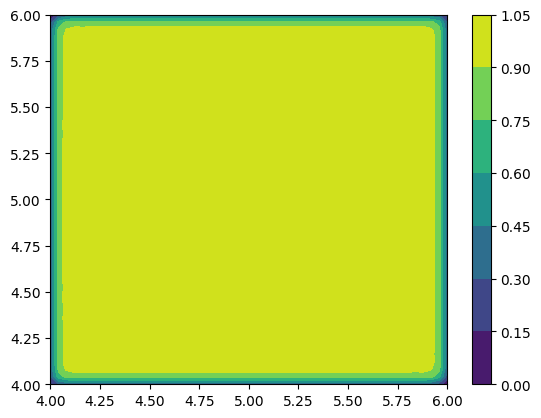

In [13]:
# the above works all you need is a plot for it 
# make a way to plot this by creating a rectangular layout of frequencies with fidelity being the third dimensional result(contour plot)

grid = np.zeros([len(freq_w3),len(freq_w4)])

for i in range(len(freq_w3)):
    for j in range(len(freq_w4)):
        grid[i][j] = fid_freqs_scan[(i * len(freq_w3)) + j]


# creating the mesh grid of the x,y values 
[xx, yy] = np.meshgrid(freq_w3,freq_w4)


# create the plot with the values populated in the matrix above
fig, axs = plt.subplots(1,1)
axs.contourf(xx, yy, grid)
axs=plt.gca()
PCM = axs.get_children()[0]
fig.colorbar(PCM)

In [14]:
# for this to be as complete as this same experiment has to be carried out when the drive is between the other qubits and not just qubit 1 and 2 it will give the true limitation of the 
# system
# note see how this impacts the setup of the desired unitary but this will be kind of difficult
# once this is carried on all of the possible iswaps in the system then one can keep superimosing those plots on top of eachother(add all of the fidelities at a given frequency point 
# together and then divide by the amount of gates. this will give the average fidelity of all possible iswap gate setups and this should yield the best result for the delta analysis)